In [28]:
import cv2
import tensorflow as tf
import numpy as np
from PIL import Image

In [6]:
model_path = r'C:\Users\1\Desktop\сase1\models\research\object_detection\rfcn_resnet101\inference_graph\frozen_inference_graph.pb'

detection_graph = tf.compat.v1.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with open(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [7]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.compat.v1.Session() as sess:
            ops = tf.compat.v1.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)

            # Запуск модели
            image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # Обработка результатов
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

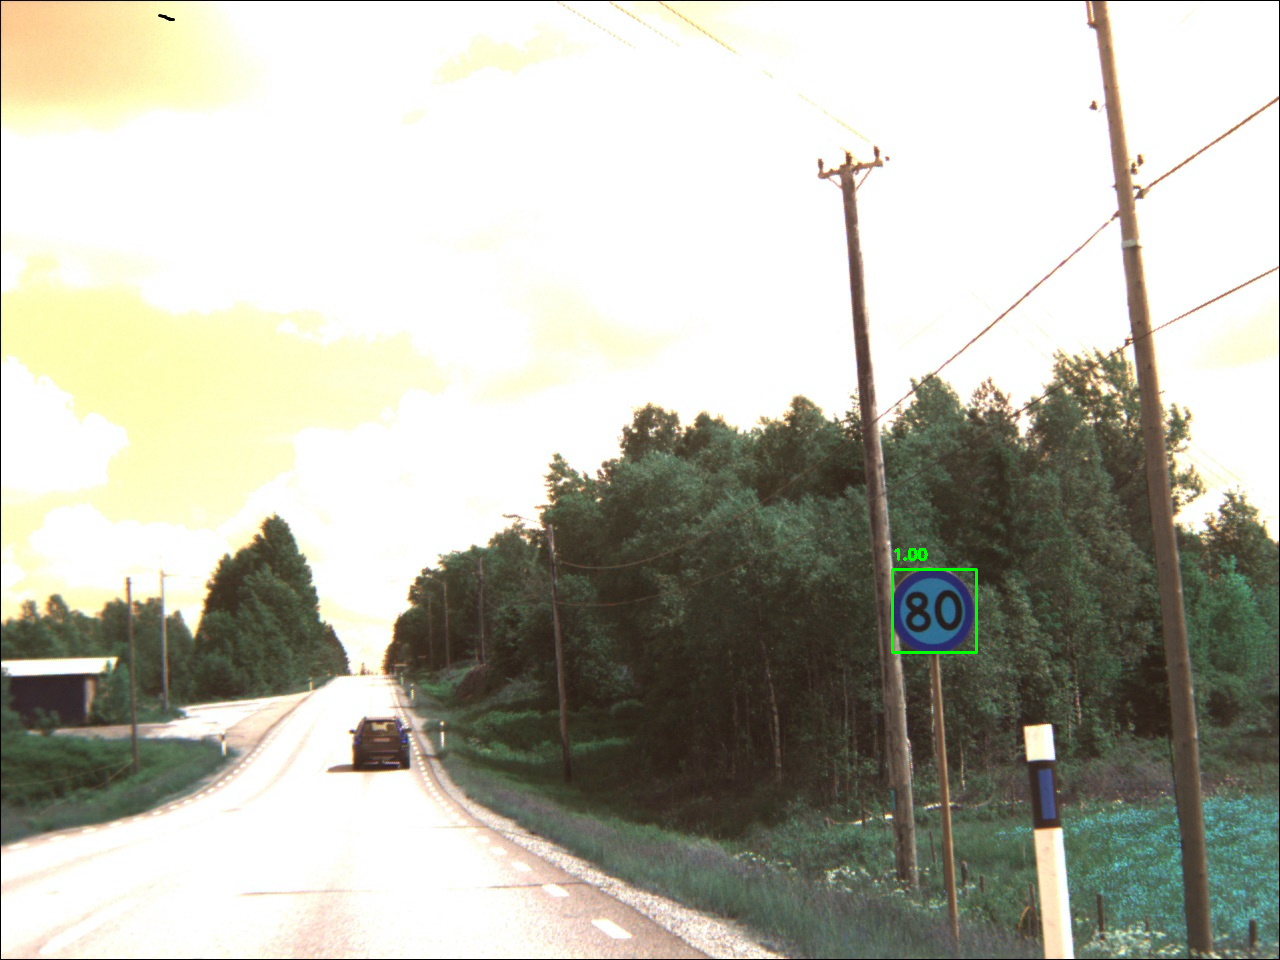

In [30]:
image_path = r'C:\Users\1\Desktop\tt.jpg'

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

output_dict = run_inference_for_single_image(image_rgb, detection_graph)

for idx in range(output_dict['num_detections']):
    if output_dict['detection_scores'][idx] > 0.5:  # Определение порога уверенности
        class_id = output_dict['detection_classes'][idx]
        score = output_dict['detection_scores'][idx]
        bbox = output_dict['detection_boxes'][idx]
      
        height, width, _ = image.shape
        ymin, xmin, ymax, xmax = bbox
        x, y, w, h = int(xmin * width), int(ymin * height), int((xmax - xmin) * width), int((ymax - ymin) * height)
        
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f'{score:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

image = Image.fromarray(image) 
display(image)